In [2]:
import pandas as pd
import numpy as np

# Load the data from the csv into a dataframe
df = pd.read_csv('word_sentiments.csv')
# Drop unnecessary column
df.drop('Unnamed: 0', axis='columns', inplace=True)

In [3]:
from gensim.models import KeyedVectors

filename = 'word2vecSmall.bin.gz'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

# Add word embeddings to dataframe
df['embedding'] = df['word'].apply(lambda x: model[x])

In [4]:
# These are the words we want to test our model with - feel free to change these!
blacklist = ['nice', 'mean', 'bad', 'good', 'sad', 'happy', 'fantastic', 'terrible']

In [5]:
# This is the data we are testing our model on (contains words in blacklist)
test_df = df[df['word'].str.lower().str.strip().isin(blacklist)].copy()
test_df.head()

,word,score,embedding
16,good,0.500,"[0.040527344, 0.0625, -0.017456055, 0.07861328..."
106,bad,-0.875,"[0.06298828, 0.12451172, 0.11328125, 0.0732421..."
164,happy,0.875,"[-0.0005187988, 0.16015625, 0.0016098022, 0.02..."
649,Good,0.500,"[-0.10888672, -0.07470703, -0.045410156, -0.00..."
717,fantastic,0.375,"[-0.122558594, -0.037841797, -0.12402344, 0.02..."


In [6]:
# This is the data we are training our model on (words NOT in blacklist)
train_df = df[~df['word'].str.lower().str.strip().isin(blacklist)].copy()
train_df.head()

,word,score,embedding
0,is,0.125,"[0.0070495605, -0.07324219, 0.171875, 0.022583..."
1,not,-0.625,"[0.08496094, -0.095214844, 0.119140625, 0.1118..."
2,will,0.125,"[0.048828125, 0.16699219, 0.16894531, 0.087402..."
3,an,-0.125,"[0.12597656, 0.19042969, 0.06982422, 0.0722656..."
4,had,0.250,"[-0.05810547, 0.05810547, 0.013305664, -0.0003..."


In [7]:
# Ensures input to LinearRegression model is in acceptable format
X_train = np.array(list(train_df['embedding'].values))
Y_train = np.array(list(train_df['score'].values))

X_test = np.array(list(test_df['embedding'].values))
Y_test = np.array(list(test_df['score'].values))

In [8]:
from sklearn.linear_model import LinearRegression

classifier = LinearRegression()

classifier.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [9]:
print("Score:", classifier.score(X_test, Y_test))

Score: 0.5823370625581086


In [10]:
# Here's an example of output from the model - 'happy' should have a higher sentiment score than 'sad'
print(classifier.predict([np.array(model['happy'])])[0])
print(classifier.predict([np.array(model['sad'])])[0])

0.27819216
-0.23761618


In [11]:
# This gets the shape of coefficients of the LinearRegression model, which we can see is the same
# as the length of the embedding input
classifier.coef_.shape

(300,)

In [12]:
# This is the intercept of the LinearRegression model
classifier.intercept_

0.059657402

In [13]:
test_df['predicted_score'] = test_df['embedding'].apply(lambda x: classifier.predict(x.reshape(1, -1))[0])
test_df.sort_values(by=['predicted_score'],inplace=True)

In [14]:
test_df.head()

,word,score,embedding,predicted_score
907,terrible,-0.625,"[0.1640625, 0.19238281, 0.092285156, 0.1308593...",-0.473126
106,bad,-0.875,"[0.06298828, 0.12451172, 0.11328125, 0.0732421...",-0.370561
8063,Terrible,-0.625,"[0.296875, -0.06640625, 0.18457031, 0.00148773...",-0.345227
1833,Bad,-0.875,"[-0.078125, -0.11279297, 0.018676758, 0.080566...",-0.327850
7451,SAD,-0.625,"[-0.017211914, -0.23046875, -0.04345703, 0.062...",-0.237694


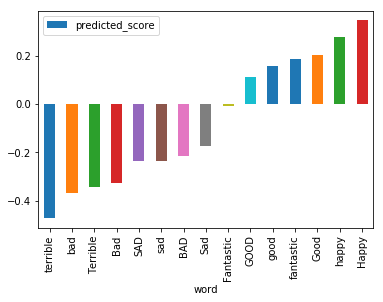

In [17]:
# A bar plot showing what our model thinks the sentiments of our test words are
test_df.plot(x='word',y='predicted_score',kind='bar')

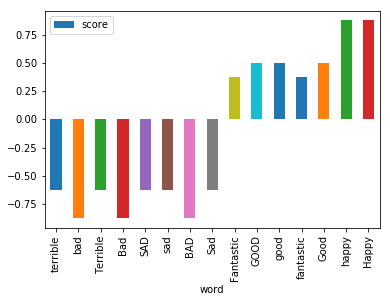

In [16]:
# Here's what they actually are - should look similar to previous plot!
test_df.plot(x='word',y='score',kind='bar')